# Transition Path

In this notebook, I solve and simulate the housing model along a **transition path** stemming from an interest rate shock

In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy import optimize
from consav import linear_interp

# load the DurableConsumptionModel module
from DurableConsumptionModel import DurableConsumptionModelClass

# Set the number of threads in numba
nb.set_num_threads(4)

## Test how PE path looks

Solve the Initial Steady State

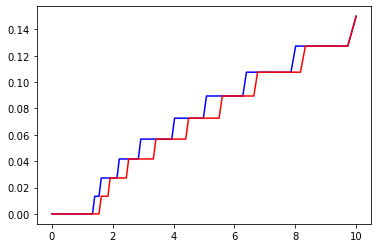

In [192]:
plt.plot(model.par.grid_m, model.sol_path.d_adj[201,0,1,:], color = 'blue', linewidth = '1.5', label = r'Low $R$')
plt.plot(model.par.grid_m, model.sol_path.d_adj[199,0,1,:], color = 'red', linewidth = '1.5', label = r'High $R$')

In [195]:
model = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm', 'do_print':False})
model.precompile_numba()
model.solve()

Solve and Simulate Along a Transition Path

In [196]:
model.solve_path()
model.simulate_path()

Plot the results

In [173]:
h_path[201]

0.07864522329353499

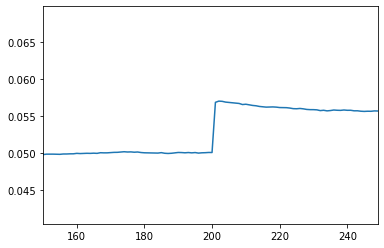

In [197]:
# define
h_path = np.mean(model.sim_path.n, axis=1)

# plot
plt.plot(range(len(h_path)),h_path)
plt.xlim(150,249)
# plt.ylim(0.045,0.065)
plt.show()

In [207]:
print(h_path[200])

0.050051953862999696


(150.0, 249.0)

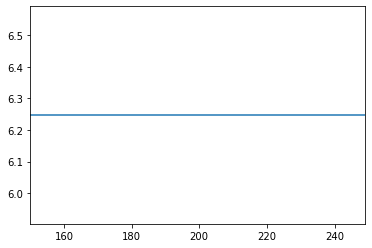

In [206]:
# plot
plt.plot(model.par.path_ph)
plt.xlim(150,249)

## Test Relaxation Algorithm

Supply function

In [140]:
# Write test function
def Hs_prime(x):
    
    # Parameters
    a = 9000
    b = 6.4593010477953685 - a*0.05
    
    # Set negatives to zero
    y = a*x + b
    
    return max(y,0)

Setup

In [141]:
# a. allocate
path_ph_ = np.zeros(50)
path_ph = np.zeros(50)

# b. setting
nu = 0.999 # relaxation parameter
max_iter = 500 # maximum number of iterations

# Set path of prices
path_ph[:] = model.par.ph
model.par.path_ph[model.par.sim_T:model.par.sim_T+50] = path_ph

Solve and simulate along path - **start here again**

In [164]:
model.solve_path()
model.simulate_path()

Find implied house price

In [174]:
for t in range(50):
    path_ph_[t] = Hs_prime(np.mean(model.sim_path.n, axis=1)[model.par.sim_T+t])

Compute difference between implied and actual prices

In [175]:
max_abs_diff = np.max(np.abs(path_ph-path_ph_))
print(max_abs_diff)

257.9573566003396


Check

In [176]:
y[0]

0.67975828934029

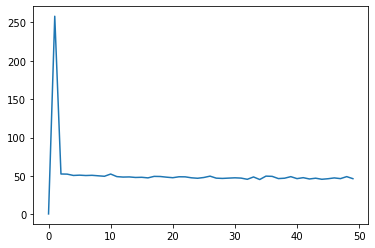

In [177]:
y = path_ph_ - path_ph
plt.plot(y)

Update price sequence

In [150]:
path_ph[0]

6.247807283741677

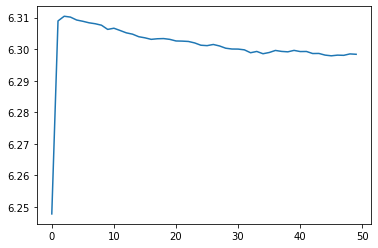

In [149]:
path_ph = nu*path_ph + (1-nu)*path_ph_
plt.plot(path_ph)

Run again with updated price sequence

In [155]:
model.par.path_ph[model.par.sim_T:model.par.sim_T+50] = path_ph

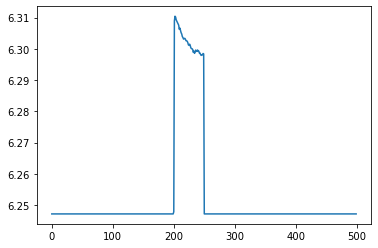

In [193]:
plt.plot(model.par.path_ph)

## Find Equilibrium Along a Transition Path

In [26]:
# Write test function
def Hs_prime(x):
    
    # Parameters
    a = 9000
    b = 6.4593010477953685 - a*0.05
    
    # Set negatives to zero
    y = a*x + b
    
    return max(y,0)

Test code

In [96]:
# a. allocate
path_ph_ = np.zeros(model_path.par.path_T)
path_ph = model_path.par.path_ph

# b. setting
nu = 0.99 # relaxation parameter
max_iter = 500 # maximum number of iterations

# ii. solve and simulate
model_path.par.path_ph[:] = model_path.par.ph
model_path.solve_path()

## Apply relaxation algorithm 

In [97]:
# Initialize model and solve initial steady state
model_path = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm', 'do_print':False})
model_path.precompile_numba()
model_path.solve()

In [107]:
# t0 = time.time()

# a. allocate
path_ph_ = np.zeros(model_path.par.path_T)
path_ph = model_path.par.path_ph

# b. setting
nu = 0.99 # relaxation parameter
max_iter = 500 # maximum number of iterations

# c. iterate
it = 0
for _ in range(max_iter):

    # ii. solve and simulate
    model_path.par.path_ph = path_ph
    model_path.solve_path()
    model_path.simulate_path()

    # iii. implied housing price
    for t in range(50):
        path_ph_[t] = Hs_prime(np.mean(model_path.sim_path.n, axis=1)[model_path.par.sim_T + t])

    # iv. difference
    max_abs_diff = np.max(np.abs(path_ph[200:]-path_ph_))
    if it%10 == 0: print(f'{it:4d}: {max_abs_diff:.8f}')
    if max_abs_diff < 1e-4: break # test different values of this threshold

    # v. update
    path_ph[model_path.par.sim_T:] = 0.9*path_ph[model_path.par.sim_T:] + (1-0.9)*path_ph_
    
    print(path_ph)
    
    # vi.  increment
    it += 1
    if it > max_iter: raise Exception('too many iterations')    
    
    print(it)

print(f'\n transtion path found in {elapsed(t0)}')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
   0: 63.34659638
[ 6.24712753  6.24712753  6.24712753  6.24712753  6.24712753  6.24712753
  6.24712753  6.24712753  6.24712753  6.24712753  6.24712753  6.24712753
  6.24712753  6.24712753  6.24712753  6.24712753  6.24712753  6.24712753
  6.24712753  6.24712753  6.24712753  6.24712753  6.24712753  6.24712753
  6.24712753  6.24712753  6.24712753  6.24712753  6.24712753  6.24712753
  6.24712753  6.24712753  6.24712753  6.24712753  6.24712753  6.24712753
  6.24712753  6.24712753  6.24712753  6.24712753  6.24712753  6.24712753
  6.24712753  6.24712753  6.24712753  6.24712753  6.24712753  6.24712753
  6.24712753  6.24712753  6.24712753  6.24712753  6.24712753  6.24712753
  6.24712753  6.24712753  6.24712753  6.24712753  6.24712753  6.24712753
  6.24712753  6.24712753  6.24712753  6.24712753  6.24712753  6.24712753
  6.24712753  6.24712753  6.24712753  6

ZeroDivisionError: division by zero

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\madsh\OneDrive - University of Copenhagen\Desktop\Thesis\code\MA_thesis\DurableConsumptionModel.py", line 504, in solve_path
    negm.solve_keep(t,sol_path,par)
SystemError: CPUDispatcher(<function solve_keep at 0x000001B6CF9E64C0>) returned a result with an error set


SystemError: CPUDispatcher(<function solve_keep at 0x000001B6CF9E64C0>) returned a result with an error set